# Recurrent Neural Networks

## Libraries

In [ ]:
# !pip install torch

In [27]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from scipy.signal import resample
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report

## Utilities

In [46]:
# Training function.
def train(epoch, model, loader, criterion, optimizer, device='cpu'):
    l = 0
    for data in tqdm(loader, desc=f'Epoch {epoch+1:03d}'):
        x = data[0].to(device)
        y = data[1].to(device)
        out = model(x)
        loss = criterion(out, y)
        l += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return l

# Test function.
def test(model, loader, criterion, device='cpu'):
    l = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            l += criterion(out, y)
            _, pred = torch.max(out.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()
    return l, correct / total, y_true, y_pred

## Data

Dataset [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/), can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/shayanfazeli/heartbeat).

In [28]:
# Read train and test data.
df_train = pd.read_csv("mitbih_train.csv", header=None)
df_test = pd.read_csv("mitbih_test.csv", header=None)

# Head of training dataframe.
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


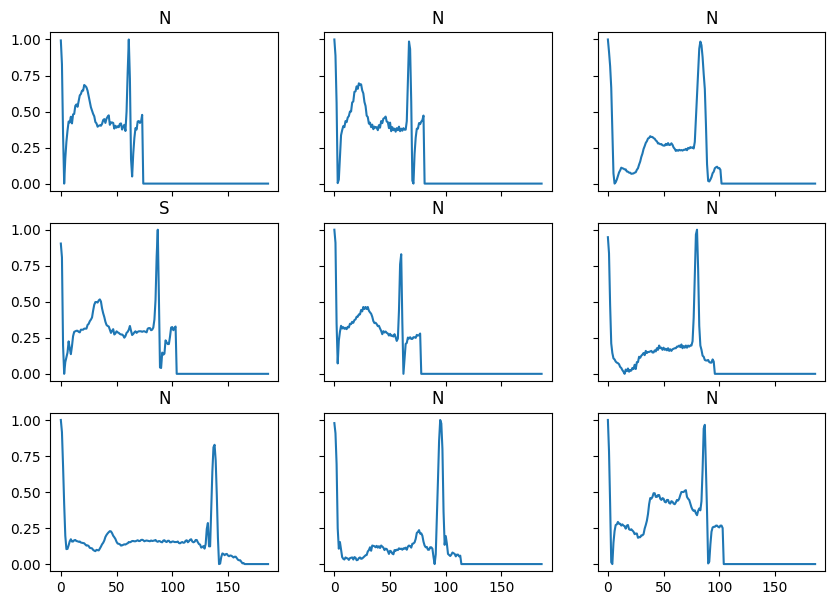

In [8]:
# From label index to label name.
labels_map = {
    0: 'N', # Normal
    1: 'S', # Fusion of paced and normal
    2: 'V', # Premature ventricular contraction
    3: 'F', # Atrial premature
    4: 'Q'  # Fusion of ventricular and normal
}

# Plot some data.
rows, cols = 3, 3
fig, ax = plt.subplots(rows, cols, figsize=(10, 7), sharex=True, sharey=True)
for r in range(rows):
    for c in range(cols):
        sample = df_train.sample(1).values.flatten()
        y = labels_map[sample[-1]]
        ax[r, c].plot(sample[:-1])
        ax[r, c].set_title(y)
plt.show()

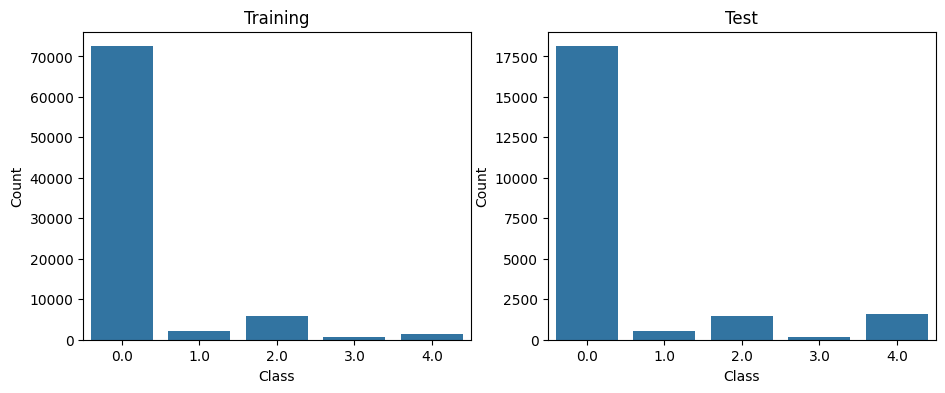

In [9]:
# Plot distributions.
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
sns.countplot(x=df_train[df_train.shape[1] - 1], ax=ax[0])
sns.countplot(x=df_test[df_test.shape[1] - 1], ax=ax[1])
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[1].set_title('Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
plt.show()

### Data Augmentation

In [17]:
# Randomly stretches the signal.
def stretch(x):
    n = x.shape[0]
    l = int(n * (1 + (random.random() - 0.5) / 3))
    y = resample(x, l)
    if l < n:
        y_ = np.zeros(shape=(n, ))
        y_[:l] = y
    else:
        y_ = y[:n]
    return y_

# Randomly amplifies the signal.
def amplify(x):
    alpha = (random.random() - 0.5)
    factor = -alpha * x + (1 + alpha)
    return x * factor

# Wrappers.
class Stretch:
    def __init__(self):
        pass

    def __call__(self,x):
        return stretch(x)

    def __repr__(self):
        return 'Stretch'

class Amplify:
    def __init__(self):
        pass

    def __call__(self,x):
        return amplify(x)

    def __repr__(self):
        return 'Amplify'

# Randomly augments the input signal.
class Augment:
    def __init__(self, aug_list, verbose=False):
        self.aug_list = aug_list
        self.verbose = verbose

    def __call__(self, x):
        augs = ''
        for i, aug in enumerate(self.aug_list):
            if np.random.binomial(1, 0.5) == 1:
                x = aug(x)
                augs += f'{aug}, ' if i < len(self.aug_list) - 1 else f'{aug}'
        if not self.verbose:
            return x
        return x, augs

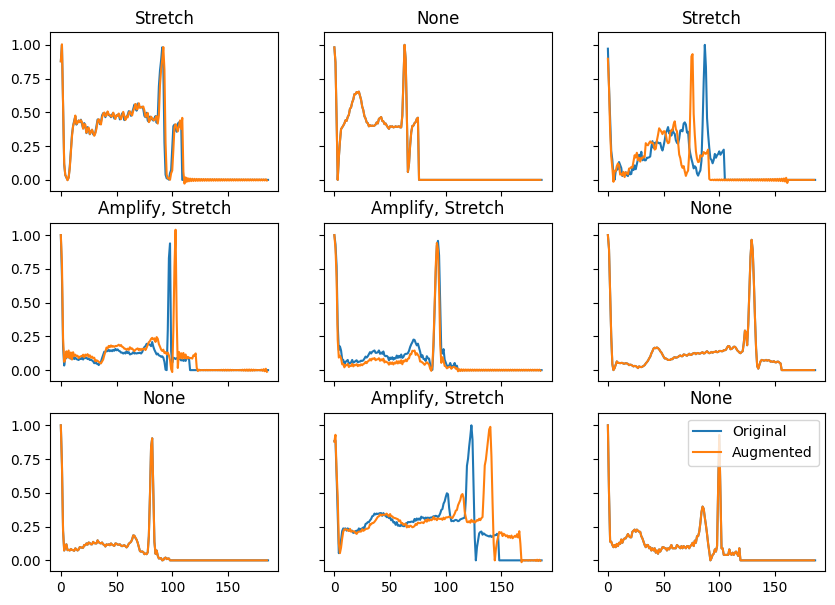

In [26]:
# New Augment object.
augment = Augment([Amplify(), Stretch()], True)

# Plot augmentations.
rows, cols = 3, 3
fig, ax = plt.subplots(rows, cols, figsize=(10, 7), sharex=True, sharey=True)
for r in range(rows):
    for c in range(cols):
        sample = df_train.sample(1).values.flatten()
        aug_sample, augs = augment(sample[:-1])
        y = labels_map[sample[-1]]
        ax[r, c].plot(sample[:-1])
        ax[r, c].plot(aug_sample[:-1])
        ax[r, c].set_title(augs if augs != '' else 'None')
plt.legend(['Original', 'Augmented'])
plt.show()

In [78]:
# Custom dataset, as we discussed in the first lecture.
class CustomDataset(Dataset):

    # Stores the data.
    def __init__(self, x, y=None, transforms=None):
        super().__init__()
        self.x = x
        self.y = y
        self.transforms = transforms

    # Returns the length of the dataset.
    def __len__(self):
        return self.x.shape[0]

    # Returns a (x, y) pair from the dataset.
    def __getitem__(self,idx):
        x = self.x.iloc[idx, :]
        if self.transforms is not None:
            x = self.transforms(x)
        if self.y is not None:
            return torch.tensor(x).float().unsqueeze(-1), torch.tensor([self.y.iloc[idx]]).type(torch.LongTensor).squeeze()
        return torch.tensor(x).float()

# New Augment object.
augment = Augment([Amplify(), Stretch()])

# Creating the Dataset objects.
train_dataset = CustomDataset(df_train.iloc[:, :-1], df_train.iloc[:, -1], transforms=augment)
test_dataset = CustomDataset(df_test.iloc[:, :-1], df_test.iloc[:, -1])

# Creating the DataLoader objects.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [107]:
for x, y in train_loader:
    print(f'x: {x.shape}, y: {y.shape}')
    break

x: torch.Size([64, 187, 1]), y: torch.Size([64])


## Model Definition

In [62]:
# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [100]:
# Model hyperparameters.
input_size = 1
hidden_size = 128
num_layers = 2
num_classes = 5

In [101]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size=64, seq_length=187, hidden_size=128)
        out = self.fc(out[:, -1, :]) # out: (batch_size=64, num_classes=5)
        return out

# New model.
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

## Training and Test

In [102]:
# Training hyperparameters.
num_epochs = 10
learning_rate = 0.0001

In [103]:
# List of training labels.
train_targets = list(df_train[df_train.shape[1] - 1])

# Computing class weights based on class frequency.
cls_weights = torch.from_numpy(compute_class_weight('balanced',
                                                    classes=np.unique(train_targets),
                                                    y=train_targets)).float().to(device)

In [ ]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss(weight=cls_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}')

In [ ]:
print(classification_report(y_true, y_pred, zero_division=0))